## NGAN Julie Lab 2 Yahoo 
### 20180476

In [ ]:
!pip install -q findspark

In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"


Charge all requirement to load spark and spark context


In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!pip install pyspark-pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyspark-pandas: filename=pyspark_pandas-0.0.7-py3-none-any.whl size=7858 sha256=e59fd3b721cd231b381ad421063b9eaea07e3861e71892d1e0b7b70128253fec
  Stored in directory: /root/.cache/pip/wheels/f3/60/f9/fe6f975cd77f58b749f1cf7ea314e6a4e91c6394e6539373a0
Successfully built pyspark-pandas


In [ ]:
!pip install pandas-datareader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### We analyze the historical stocks of NASDAQ between 2018 and 2019

**Opening price** : 1st price a stock trades at when the market opens at 9:30 a.m.

**Closing price** : last price it trades at when the market closes at 4:00 p.m.

**High** : High Peak price 

**Low** : Low Peak price

**Adjusted Closing Price (Adj Close)** : amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [ ]:
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

# download dataframe
amazon = pdr.get_data_yahoo("AMZN", start="2010-01-01", end="2019-04-30").reset_index()
google = pdr.get_data_yahoo("GOOG", start="2010-01-01", end="2019-04-30").reset_index()
apple = pdr.get_data_yahoo("AAPL", start="2010-01-01", end="2019-04-30").reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Exploration

In [ ]:
amazondf = spark.createDataFrame(amazon)
googledf = spark.createDataFrame(google)
appledf = spark.createDataFrame(apple)

In [ ]:
amazondf.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)



Explore the different stocks historical prices and try to code functions that will look at the
dataframe and extract some useful information about the input data:


In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import desc, stddev, mean, min, max
from pyspark.sql.functions import col,isnan, when, count
from scipy.stats import pearsonr
from pyspark.mllib.stat import Statistics


def information(sparkdf):
  sparkdf.show(40)
  
  ## Extract last N rows of the dataframe in pyspark
  df_reverse = sparkdf.withColumn("index", monotonically_increasing_id())
  df_reverse.orderBy(desc("index")).drop("index").show(40)

information(amazondf)
information(googledf)
information(appledf)

+-------------------+------------------+-----------------+------------------+------------------+------------------+---------+
|               Date|              Open|             High|               Low|             Close|         Adj Close|   Volume|
+-------------------+------------------+-----------------+------------------+------------------+------------------+---------+
|2010-01-04 00:00:00|            6.8125| 6.83050012588501|6.6570000648498535| 6.695000171661377| 6.695000171661377|151998000|
|2010-01-05 00:00:00| 6.671500205993652| 6.77400016784668|6.5904998779296875| 6.734499931335449| 6.734499931335449|177038000|
|2010-01-06 00:00:00| 6.730000019073486|6.736499786376953| 6.582499980926514| 6.612500190734863| 6.612500190734863|143576000|
|2010-01-07 00:00:00| 6.600500106811523|6.616000175476074| 6.440000057220459|               6.5|               6.5|220604000|
|2010-01-08 00:00:00|6.5279998779296875|6.684000015258789| 6.451499938964844| 6.676000118255615| 6.676000118255615|196

Get the number of observations
o Descriptive statistics for each dataframe and each column (min, max, standard deviation)"""

In [ ]:
def get_stats_column(sparkdf):
  sparkdf.summary().show()

get_stats_column(amazondf)
get_stats_column(googledf)
get_stats_column(appledf)

+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|summary|              Open|              High|               Low|             Close|         Adj Close|              Volume|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|  count|              2345|              2345|              2345|              2345|              2345|                2345|
|   mean| 29.62761194639877| 29.92561962091084|29.284727737288485|29.621532581508287|29.621532581508287|  9.22286302771855E7|
| stddev|25.405562646057774|25.648513853306472| 25.09884581279958| 25.38414048235787| 25.38414048235787|5.8473405078793965E7|
|    min| 5.296500205993652| 5.564499855041504| 5.289999961853027| 5.430500030517578| 5.430500030517578|            19688000|
|    25%|11.029500007629395|11.224499702453613|10.899999618530273|11.029999732971191|11.029999732971191|            56

Number of missing values for each dataframe and column

In [ ]:
def missing_values(sparkdf):
  sparkdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sparkdf.columns if c != 'Date']).show()

missing_values(amazondf)
missing_values(googledf)
missing_values(appledf)

+----+----+---+-----+---------+------+
|Open|High|Low|Close|Adj Close|Volume|
+----+----+---+-----+---------+------+
|   0|   0|  0|    0|        0|     0|
+----+----+---+-----+---------+------+

+----+----+---+-----+---------+------+
|Open|High|Low|Close|Adj Close|Volume|
+----+----+---+-----+---------+------+
|   0|   0|  0|    0|        0|     0|
+----+----+---+-----+---------+------+

+----+----+---+-----+---------+------+
|Open|High|Low|Close|Adj Close|Volume|
+----+----+---+-----+---------+------+
|   0|   0|  0|    0|        0|     0|
+----+----+---+-----+---------+------+



### Correlation between columns : here, High and Low, Open and Close...

The Pearson correlation coefficient (named for Karl Pearson) can be used to summarize the strength of the linear relationship between two data samples.

The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score.

Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))

In [ ]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def values_correlation(sparkdf):
  assembler = VectorAssembler(inputCols=['Open', 'Close', 'High', 'Low', 'Adj Close'], outputCol = 'features')
  output = assembler.transform(sparkdf)
  pearsonCorr = Correlation.corr(output, 'features', 'pearson').collect()[0][0]
  print(str(pearsonCorr).replace('nan', 'NaN'))

print('Correlation matrix for Open, Close, High, Low, Adj Close of Amazon stock prices')
values_correlation(amazondf)

print('\n Correlation matrix for Open, Close, High, Low, Adj Close of Google stock prices')
values_correlation(googledf)

print('\n Correlation matrix for Open, Close, High, Low, Adj Close of Apple stock prices')
values_correlation(appledf)


Correlation matrix for Open, Close, High, Low, Adj Close of Amazon stock prices


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[1.        , 0.99969264, 0.99988519, 0.99980555, 0.99969264],
             [0.99969264, 1.        , 0.99984215, 0.99986404, 1.        ],
             [0.99988519, 0.99984215, 1.        , 0.99976308, 0.99984215],
             [0.99980555, 0.99986404, 0.99976308, 1.        , 0.99986404],
             [0.99969264, 1.        , 0.99984215, 0.99986404, 1.        ]])

 Correlation matrix for Open, Close, High, Low, Adj Close of Google stock prices
DenseMatrix([[1.        , 0.99961468, 0.99984795, 0.99977918, 0.99961468],
             [0.99961468, 1.        , 0.99979878, 0.9998496 , 1.        ],
             [0.99984795, 0.99979878, 1.        , 0.99974832, 0.99979878],
             [0.99977918, 0.9998496 , 0.99974832, 1.        , 0.9998496 ],
             [0.99961468, 1.        , 0.99979878, 0.9998496 , 1.        ]])

 Correlation matrix for Open, Close, High, Low, Adj Close of Apple stock prices
DenseMatrix([[1.        , 0.99958686, 0.99982406, 0.99976707, 0.99864352],
          

### Average of the opening and closing prices for each stock price and for
different time periods (week, month, year)?

In [ ]:
from pyspark.sql.functions import year, month, weekofyear, dayofyear
from pyspark.sql.functions import to_date, col, avg, lit, when

def avg_open_close_by_stock(sparkdf):
  # create year column
  sparkdf = sparkdf.withColumn("year", year(col('Date')))
  avg_year_open = sparkdf.groupBy("year").avg("Open")
  avg_year_close = sparkdf.groupBy("year").avg("Close")
  
  avg_y = avg_year_open.join(avg_year_close, on="year")
  avg_y.show()

  # create month
  sparkdf = sparkdf.withColumn("month", month(col('Date')))
  avg_month_open = sparkdf.groupBy("month").avg("Open")
  avg_month_close = sparkdf.groupBy("month").avg("Close")
  
  avg_m = avg_month_open.join(avg_month_close, on="month")
  avg_m.show()

  # create week
  sparkdf = sparkdf.withColumn("week", weekofyear(col('Date')))
  avg_week_open = sparkdf.groupBy("week").avg("Open")
  avg_week_close = sparkdf.groupBy("week").avg("Close")

  avg_w = avg_week_open.join(avg_week_close, on="week")
  avg_w.show()

  # create day
  sparkdf = sparkdf.withColumn("day", dayofyear(col('Date')))

  return sparkdf, avg_w,avg_m,avg_y

In [ ]:
print("Average of Amazon stock prices")
amazondf, amazon_avg_w, amazon_avg_m, amazon_avg_y = avg_open_close_by_stock(amazondf)

print("Average of Google stock prices")
googledf, google_avg_w, google_avg_m, google_avg_y = avg_open_close_by_stock(googledf)

print("Average of Apple stock prices")
appledf, apple_avg_w, apple_avg_m, apple_avg_y =avg_open_close_by_stock(appledf)

Average of Amazon stock prices
+----+------------------+------------------+
|year|         avg(Open)|        avg(Close)|
+----+------------------+------------------+
|2013|14.893755954409402|14.901579402741932|
|2014| 16.63992256209964|16.627551608615452|
|2012| 11.00055197906494| 11.01518200302124|
|2010| 6.947918657272581| 6.957019838075789|
|2011| 9.833484116054716| 9.833601175792634|
|2018| 82.20363548552372| 82.08630852870257|
|2015| 23.90624807751368| 23.90691463909452|
|2019|  85.4929936726888| 85.67194441807123|
|2016|34.987829427870494| 34.97615664345877|
|2017| 48.41378091151021| 48.40835056076962|
+----+------------------+------------------+

+-----+------------------+------------------+
|month|         avg(Open)|        avg(Close)|
+-----+------------------+------------------+
|   12|29.795340441642924|29.688303064792713|
|    1|29.448537139609307|29.517792076167495|
|    6|27.621266938244123| 27.60079269458593|
|    3| 30.48698394670399|30.506917397910303|
|    5|26.948212

#### Insight 1 : stock price per period

In [ ]:
import pandas as pd

def histogram_period(sparkdf, period, avg_column):
  """
  sparkdf : dataframe avarage by period
  """
  gre_histogram = sparkdf.select(avg_column).rdd.flatMap(lambda x: x).histogram(11)

  # Loading the Computed Histogram into a Pandas Dataframe for plotting
  pd.DataFrame(list(zip(*gre_histogram)), 
      columns=[period, avg_column]).set_index(period).plot(kind='bar')

In [ ]:
import pyspark.pandas as ps

0    14.893756
dtype: float64

Amazon
Google
Apple


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f401b53d160>]],
      dtype=object)

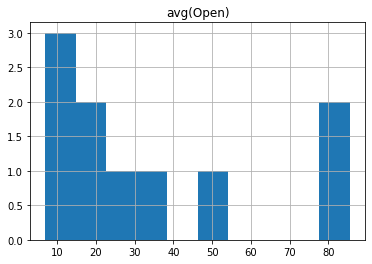

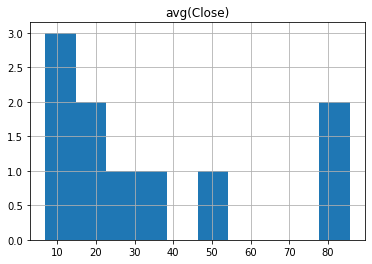

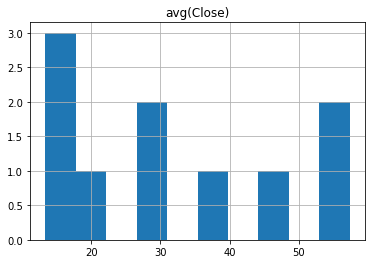

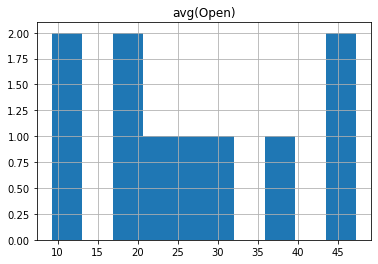

In [ ]:
print("Amazon")
amazon_avg_y.toPandas().hist('avg(Open)')
amazon_avg_y.toPandas().hist('avg(Close)')

print("Google")
google_avg_y.toPandas().hist('avg(Close)')

print("Apple")
apple_avg_y.toPandas().hist('avg(Open)')

#### Insight 2 : Evolution comparison of Stocks

In [ ]:
df = ps.DataFrame({'Amazon': amazondf.select('Close').rdd.flatMap(lambda x:x).collect(),
                   'Google': googledf.select('Close').rdd.flatMap(lambda x:x).collect(),
                   'Apple': appledf.select('Close').rdd.flatMap(lambda x:x).collect()},
                  index=amazondf.select('Date').rdd.flatMap(lambda x:x).collect())
df.plot.line()  

Price by period for Amazon


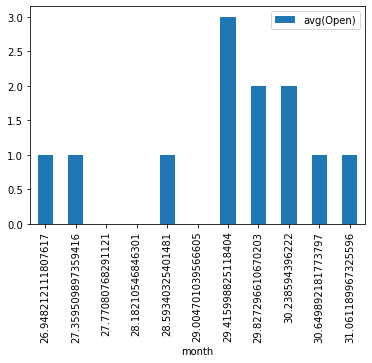

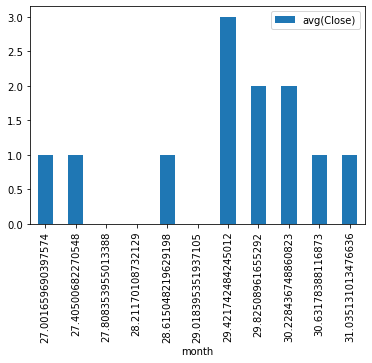

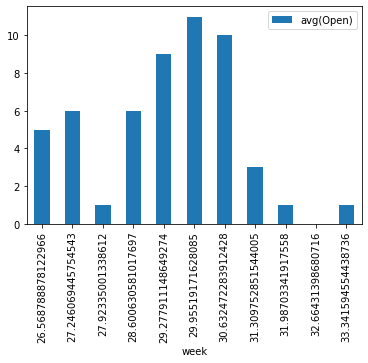

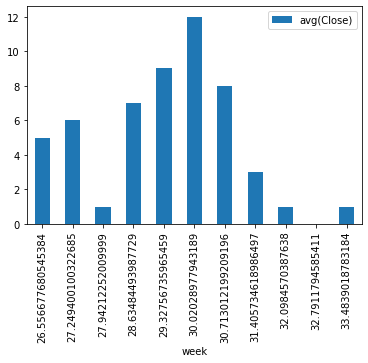

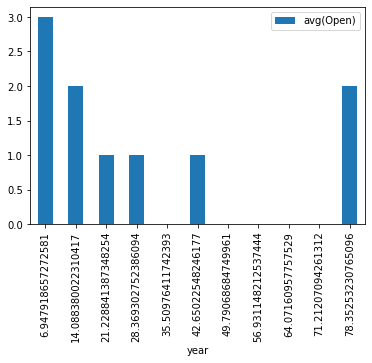

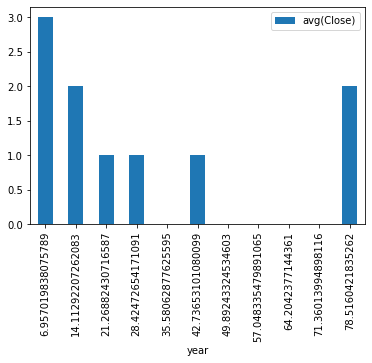

In [ ]:
print("Price by period for Amazon")
histogram_period(amazon_avg_m, 'month', 'avg(Open)')
histogram_period(amazon_avg_m, 'month', 'avg(Close)')
histogram_period(amazon_avg_w, 'week', 'avg(Open)')
histogram_period(amazon_avg_w, 'week', 'avg(Close)')
histogram_period(amazon_avg_y, 'year', 'avg(Open)')
histogram_period(amazon_avg_y, 'year', 'avg(Close)')

In [ ]:
print("Price by period for Google")
histogram_period(google_avg_m, 'month', 'avg(Open)')
histogram_period(google_avg_m, 'month', 'avg(Close)')
histogram_period(google_avg_w, 'week', 'avg(Open)')
histogram_period(google_avg_w, 'week', 'avg(Close)')
histogram_period(google_avg_y, 'year', 'avg(Open)')
histogram_period(google_avg_y, 'year', 'avg(Close)')

In [ ]:
print("Price by period for Apple")
histogram_period(apple_avg_m, 'month', 'avg(Open)')
histogram_period(apple_avg_m, 'month', 'avg(Close)')
histogram_period(apple_avg_w, 'week', 'avg(Open)')
histogram_period(apple_avg_w, 'week', 'avg(Close)')
histogram_period(apple_avg_y, 'year', 'avg(Open)')
histogram_period(apple_avg_y, 'year', 'avg(Close)')

Stock price evolution day to day and month to month (maybe you can create new columns to save those calculation)?

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType

def previous(my_window, sparkdf):
  open_prev_value = F.lag(sparkdf.Open).over(my_window)
  return open_prev_value

def compute_evolution(sparkdf):
  evo = F.when(F.isnull(sparkdf.Open - sparkdf.open_prev_value), 0).otherwise(sparkdf.Open - sparkdf.open_prev_value)
  return evo

def evolution(sparkdf):
  my_window = Window.partitionBy("Date").orderBy("month")
  month_evolution = sparkdf.withColumn("open_prev_value", F.lag(sparkdf.Open).over(my_window)) 
  month_evolution = sparkdf.groupBy("month").count()
  month_evolution = sparkdf.withColumn("diff_month", F.when(F.isnull(sparkdf.Open - sparkdf.open_prev_value), 0)
                                .otherwise(sparkdf.Open - sparkdf.open_prev_value))
  
  my_window_day = Window.partitionBy("Date").orderBy("day")
  sparkdf = sparkdf.withColumn("open_prev_value_day", F.lag(sparkdf.Open).over(my_window_day))
  sparkdf = sparkdf.withColumn("diff_day", F.when(F.isnull(sparkdf.Open - sparkdf.open_prev_value_day), 0)
                                .otherwise(sparkdf.Open - sparkdf.open_prev_value_day))
  
  return sparkdf, month_evolution

amazondf, mamazon = evolution(amazondf)
googledf, mgoogle = evolution(googledf)
appledf, mapple = evolution(appledf)

In [ ]:
amazondf.show()
mamazon.show()

+-------------------+------------------+-----------------+------------------+-----------------+-----------------+---------+----+-----+----+------------------+-------------------+--------+---+
|               Date|              Open|             High|               Low|            Close|        Adj Close|   Volume|year|month|week|   open_prev_value|open_prev_value_day|diff_day|day|
+-------------------+------------------+-----------------+------------------+-----------------+-----------------+---------+----+-----+----+------------------+-------------------+--------+---+
|2010-01-04 00:00:00|            6.8125| 6.83050012588501|6.6570000648498535|6.695000171661377|6.695000171661377|151998000|2010|    1|   1|              null|               null|     0.0|  4|
|2010-01-05 00:00:00| 6.671500205993652| 6.77400016784668|6.5904998779296875|6.734499931335449|6.734499931335449|177038000|2010|    1|   1|            6.8125|               null|     0.0|  5|
|2010-01-06 00:00:00| 6.730000019073486|

Based on the opening and closing price, calculate the daily return of each stock


In [ ]:
def daily_return(sparkdf):
  sparkdf = sparkdf.withColumn("daily_return", F.when(F.isnull(sparkdf.Close - sparkdf.Open), 0)
                                .otherwise(sparkdf.Close - sparkdf.Open))
  return sparkdf

In [ ]:
amazondf = daily_return(amazondf)
googledf = daily_return(googledf)
appledf = daily_return(appledf)

In [ ]:
appledf.show()
googledf.show()
appledf.show()

+-------------------+------------------+------------------+------------------+------------------+------------------+----------+----+-----+----+------------------+-------------------+--------+---+--------------------+
|               Date|              Open|              High|               Low|             Close|         Adj Close|    Volume|year|month|week|   open_prev_value|open_prev_value_day|diff_day|day|        daily_return|
+-------------------+------------------+------------------+------------------+------------------+------------------+----------+----+-----+----+------------------+-------------------+--------+---+--------------------+
|2010-01-04 00:00:00| 7.622499942779541| 7.660714149475098| 7.585000038146973| 7.643214225769043| 6.515211582183838| 493729600|2010|    1|   1|              null|               null|     0.0|  4|0.020714282989501953|
|2010-01-05 00:00:00| 7.664286136627197| 7.699643135070801|7.6160712242126465| 7.656428813934326|6.5264763832092285| 601904800|2010|

Stocks with the highest daily return

In [ ]:
def highest_daily_return(sparkdf):
  sparkdf.select(max("daily_return")).show()

In [ ]:
highest_daily_return(amazondf)
highest_daily_return(googledf)
highest_daily_return(appledf)

+-----------------+
|max(daily_return)|
+-----------------+
|5.100494384765625|
+-----------------+

+------------------+
| max(daily_return)|
+------------------+
|2.6709976196289062|
+------------------+

+-----------------+
|max(daily_return)|
+-----------------+
|2.217498779296875|
+-----------------+



Average daily return for different periods (week, month, and year)

In [ ]:
def avg_daily_return(sparkdf):
  sparkdf.groupBy('week').avg("daily_return").show()
  sparkdf.groupBy('month').avg("daily_return").show()
  sparkdf.groupBy('year').avg("daily_return").show()

In [ ]:
print("Average daily return by week, month and year of Amazon")
avg_daily_return(amazondf)

print("Average daily return by week, month and year of Google")
avg_daily_return(googledf)

print("Average daily return by week, month and year of Apple")
avg_daily_return(appledf)

Average daily return by week, month and year of Amazon
+----+--------------------+
|week|   avg(daily_return)|
+----+--------------------+
|  31|-0.11232234107123482|
|  34|8.443938361273872E-4|
|  28| 0.08431110382080079|
|  26|-0.06025575002034505|
|  27| 0.07784714963701037|
|  44|0.006221172421477562|
|  12| 0.04953052559677435|
|  22| 0.06488890118069118|
|  47| 0.02475628486046424|
|   1| 0.15333731229915176|
|  52| 0.08444561829438081|
|  13|-0.00784066382874...|
|   6|-0.02624993324279785|
|  16| 0.03270206045597158|
|   3|-0.02138643915002...|
|  20|-0.01211119757758...|
|  40|-0.10382233725653754|
|  48| 0.06055945441836402|
|   5| -0.1257699489593506|
|  19| 0.05300000508626302|
+----+--------------------+
only showing top 20 rows

+-----+--------------------+
|month|   avg(daily_return)|
+-----+--------------------+
|   12|-0.10703737685020934|
|    1| 0.06925493655818524|
|    6|-0.02047424365819427|
|    3|0.019933451206312267|
|    5| 0.05344757858995368|
|    9|-0.00768

#### Moving average
<p>The moving average is calculated by adding a stock's prices over a certain period and dividing the sum by the total number of periods. For example, if you want to
calculate the moving average for the opening price of the stock ABC. 
</p>
<p>
You look at the opening
price over five periods and calculate the average. For example, if the opening price over the
past five days were 25.40, 25.90. 26.50, 26.30 and 27.90. Then, the moving average of the
opening price of the last day is 26.40.</p>

In [ ]:
from pyspark.sql.functions import desc, row_number, when

def moving_average(sparkdf, column_name, nb_points):
  sparkdf = sparkdf.withColumn('moving_average', F.avg(column_name).over(Window.partitionBy(F.window("Date", nb_points))))
  sparkdf.show()
  return sparkdf
  

In [ ]:
moving_average(amazondf, 'Open', '7 days')
moving_average(googledf, 'Open', '7 days')
moving_average(appledf, 'Open', '7 days')

+-------------------+------------------+-----------------+------------------+-----------------+-----------------+---------+----+-----+----+------------------+-------------------+--------+---+--------------------+-----------------+
|               Date|              Open|             High|               Low|            Close|        Adj Close|   Volume|year|month|week|   open_prev_value|open_prev_value_day|diff_day|day|        daily_return|   moving_average|
+-------------------+------------------+-----------------+------------------+-----------------+-----------------+---------+----+-----+----+------------------+-------------------+--------+---+--------------------+-----------------+
|2010-01-04 00:00:00|            6.8125| 6.83050012588501|6.6570000648498535|6.695000171661377|6.695000171661377|151998000|2010|    1|   1|              null|               null|     0.0|  4|-0.11749982833862305| 6.73800007502238|
|2010-01-05 00:00:00| 6.671500205993652| 6.77400016784668|6.5904998779296875

DataFrame[Date: timestamp, Open: double, High: double, Low: double, Close: double, Adj Close: double, Volume: bigint, year: int, month: int, week: int, open_prev_value: double, open_prev_value_day: double, diff_day: double, day: int, daily_return: double, moving_average: double]

#### Correlation
Is there any correlation between the different stocks you have? 
(you should decide what is the data type that will
handle the values) and calculate the correlation between them

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
def stock_correlation(stock1, stock2, stock3):
  # Merge stocks
  symbols_list = [stock1, stock2, stock3]
  symbols=[]

  for ticker in symbols_list: 
      r = pdr.get_data_yahoo(ticker , start="2010-01-01", end="2019-04-30")
      r['Symbol'] = ticker 
      symbols.append(r)

  df = pd.concat(symbols)
  df = df.reset_index()
  df = df[['Date', 'Close', 'Symbol']]

  # Pivot
  df_pivot = df.pivot(index='Date', columns='Symbol', values='Close').reset_index()
  print(df_pivot.head())
  df_pivot = spark.createDataFrame(df_pivot)
  
  assembler = VectorAssembler(inputCols=[stock1, stock2, stock3], outputCol = 'features')
  output = assembler.transform(df_pivot)
  pearsonCorr = Correlation.corr(output, 'features', 'pearson').collect()[0][0].toArray()
  print(str(pearsonCorr).replace('nan', 'NaN'))

  #del pearsonCorr.index

  mask = np.zeros_like(pearsonCorr)
  mask[np.triu_indices_from(mask)] = True
  
  seaborn.heatmap(pearsonCorr, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
  plt.yticks(rotation=0) 
  plt.xticks(rotation=90) 
  plt.show()

  return df_pivot


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Symbol       Date      AAPL    AMZN      GOOGL
0      2010-01-04  7.643214  6.6950  15.684434
1      2010-01-05  7.656429  6.7345  15.615365
2      2010-01-06  7.534643  6.6125  15.221722
3      2010-01-07  7.520714  6.5000  14.867367
4      2010-01-08  7.570714  6.6760  15.065566


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



[[1.         0.93539009 0.91904409]
 [0.93539009 1.         0.94883801]
 [0.91904409 0.94883801 1.        ]]


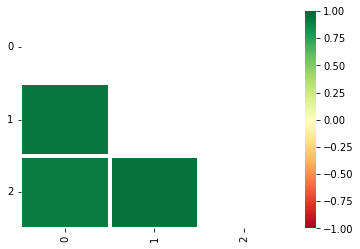

DataFrame[Date: timestamp, AAPL: double, AMZN: double, GOOGL: double]

In [ ]:
stock_correlation('AAPL', 'GOOGL', 'AMZN')

### Return rate of the stock in different periods (week, month and year) 
When investing in stocks, the return rate is very important. 
A simple rate of return is calculated by subtracting the initial value of the investment from its current value, and then dividing it by the initial value.

In [ ]:
def return_rate(sparkdf):
  # get current value
  weekly = Window().partitionBy("Open").orderBy(col("week").asc())

  # get all stock prices through weeks
  sparkdf = sparkdf.withColumn("open_prev_value",F.lag(sparkdf.Open).over(weekly))

  sparkdf = sparkdf.withColumn("row",row_number().over(weekly))
  sparkdf = sparkdf.withColumn("weekly_return_rate", F.when(F.isnull((sparkdf.Open - sparkdf.open_prev_value)/sparkdf.open_prev_value), 0)
                                       .otherwise((sparkdf.Open - sparkdf.open_prev_value)/sparkdf.open_prev_value))
  
  # get all stock prices through months
  monthly = Window().partitionBy("Open").orderBy(col("month").asc())
  sparkdf = sparkdf.withColumn("open_prev_value_m",F.lag(sparkdf.Open).over(monthly))

  sparkdf = sparkdf.withColumn("row",row_number().over(monthly))
  sparkdf = sparkdf.withColumn("monthly_return_rate", F.when(F.isnull((sparkdf.Open - sparkdf.open_prev_value_m)/sparkdf.open_prev_value_m), 0)
                                       .otherwise((sparkdf.Open - sparkdf.open_prev_value_m)/sparkdf.open_prev_value_m))

  # get all stock prices through years
  yearly = Window().partitionBy("Open").orderBy(col("year").asc())
  sparkdf = sparkdf.withColumn("open_prev_value_y",F.lag(sparkdf.Open).over(yearly))

  sparkdf = sparkdf.withColumn("row",row_number().over(yearly))
  sparkdf = sparkdf.withColumn("yearly_return_rate", F.when(F.isnull((sparkdf.Open - sparkdf.open_prev_value_y)/sparkdf.open_prev_value_y), 0)
                                       .otherwise((sparkdf.Open - sparkdf.open_prev_value_y)/sparkdf.open_prev_value_y))
  """diff = sparkdf.select('Open').collect()[0][0] - sparkdf.select('Open').collect()[5][0]
  rate = diff/spydf.select('Open').collect()[5][0]"""
  sparkdf.show()
  return sparkdf

In [ ]:
amazondf = return_rate(amazondf)
googledf = return_rate(googledf)
appledf = return_rate(appledf)



+-------------------+-----------------+-----------------+------------------+------------------+------------------+---------+----+-----+----+---------------+-------------------+--------+---+--------------------+---+------------------+-----------------+-------------------+-----------------+------------------+
|               Date|             Open|             High|               Low|             Close|         Adj Close|   Volume|year|month|week|open_prev_value|open_prev_value_day|diff_day|day|        daily_return|row|weekly_return_rate|open_prev_value_m|monthly_return_rate|open_prev_value_y|yearly_return_rate|
+-------------------+-----------------+-----------------+------------------+------------------+------------------+---------+----+-----+----+---------------+-------------------+--------+---+--------------------+---+------------------+-----------------+-------------------+-----------------+------------------+
|2010-07-23 00:00:00|5.296500205993652|5.964000225067139| 5.2899999618530

### Return rate for each stock and the best return rate

Given a specific month, what is the stock with the best return rate. 

In [ ]:
def return_rate_by_stock(sparkdf, start_date, period):
  if period == 'week':
    weekly = Window().partitionBy("Open").orderBy(col("week").asc())
    sparkdf = sparkdf.withColumn("open_prev_value",F.lag(sparkdf.Open).over(weekly))

    sparkdf = sparkdf.withColumn("row",row_number().over(weekly))
    sparkdf = sparkdf.withColumn("weekly_return_rate", F.when(F.isnull((sparkdf.Open - sparkdf.open_prev_value)/sparkdf.open_prev_value), 0)
                                        .otherwise((sparkdf.Open - sparkdf.open_prev_value)/sparkdf.open_prev_value))
    best = sparkdf.select(max("weekly_return_rate"))

  if period == 'month':
    monthly = Window().partitionBy("Open").orderBy(col("month").asc())
    sparkdf = sparkdf.withColumn("open_prev_value_m",F.lag(sparkdf.Open).over(monthly))

    sparkdf = sparkdf.withColumn("row",row_number().over(monthly))
    sparkdf = sparkdf.withColumn("monthly_return_rate", F.when(F.isnull((sparkdf.Open - sparkdf.open_prev_value_m)/sparkdf.open_prev_value_m), 0)
                                        .otherwise((sparkdf.Open - sparkdf.open_prev_value_m)/sparkdf.open_prev_value_m))
    best = sparkdf.select(max("monthly_return_rate"))

  if period == 'year':
    yearly = Window().partitionBy("Open").orderBy(col("year").asc())
    sparkdf = sparkdf.withColumn("open_prev_value_y",F.lag(sparkdf.Open).over(yearly))

    sparkdf = sparkdf.withColumn("row",row_number().over(yearly))
    sparkdf = sparkdf.withColumn("yearly_return_rate", F.when(F.isnull((sparkdf.Open - sparkdf.open_prev_value_y)/sparkdf.open_prev_value_y), 0)
                                        .otherwise((sparkdf.Open - sparkdf.open_prev_value_y)/sparkdf.open_prev_value_y))
    best = sparkdf.select(max("yearly_return_rate"))
    
  best.show()
  return

In [ ]:
return_rate_by_stock(amazondf, '2010-08-24 00:00:00', 'month')
return_rate_by_stock(googledf, '2010-08-24 00:00:00', 'month')
return_rate_by_stock(appledf, '2010-08-24 00:00:00', 'month')

+------------------------+
|max(monthly_return_rate)|
+------------------------+
|                     0.0|
+------------------------+

+------------------------+
|max(monthly_return_rate)|
+------------------------+
|                     0.0|
+------------------------+

+------------------------+
|max(monthly_return_rate)|
+------------------------+
|                     0.0|
+------------------------+



## Analysis and visualizations : 8 insights of stock prices
#### insight 4 : Candlestick

Insight of open, close, high low per day

In [ ]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
from pyspark.sql.functions import col


def candlestick(sparkdf):
  data=[go.Candlestick(x=sparkdf.rdd.map(lambda x: x[0]).collect(),
                  open=sparkdf.rdd.map(lambda x: x[1]).collect(),
                  high=sparkdf.rdd.map(lambda x: x[2]).collect(),
                  low=sparkdf.rdd.map(lambda x: x[3]).collect(),
                  close=sparkdf.rdd.map(lambda x: x[4]).collect())]
  fig = go.Figure(data, layout_title_text="Candlestick")
  fig.show()

candlestick(amazondf)
candlestick(googledf)
candlestick(appledf)

The exploration process is the opportunity for you to gain a good understanding of the data you are working with. Work on your imagination (helped with some google research) and think about 8 insights that can be helpful for our use case.